# Data Frame Query + Visualization w/ Polars

In [1]:
import polars as pl
import pyarrow as pa
import pyarrow.parquet as pq
from pyarrow import orc

In [3]:
pyarrow_orc = orc.read_table('/home/jovyan/work/shared-datasets/nasdaq.orc')
schema_overrides = {"ticker":pl.Utf8, "per":pl.Utf8}
df_polars_orc_via_arrow_with_overrides = pl.from_arrow(pyarrow_orc, schema_overrides = schema_overrides)

In [5]:
 query = (
    df_polars_orc_via_arrow_with_overrides.filter(pl.col('ticker')=='AACG.US')
    .lazy()
    .groupby([
            pl.col('ticker'),
            pl.col('recordtime').cast(pl.Date).alias('mydate')
         ])
    .agg([
        pl.count().alias('row'),
        pl.max('high'),
        pl.min('open'),
        pl.min('close'),
        pl.min('low'),
        pl.sum('vol').alias('totalvol')
    ])
    .sort([pl.col('ticker'), 'mydate'])
)
results = query.collect()
results.head(5)

ticker,mydate,row,high,open,close,low,totalvol
str,date,u32,f64,f64,f64,f64,f64
"""AACG.US""",2008-01-28,1,0.738,0.738,0.738,0.738,0.0
"""AACG.US""",2008-01-29,1,0.776,0.738,0.6797,0.6657,1.9169939e7
"""AACG.US""",2008-01-30,1,0.7108,0.6797,0.6603,0.6448,2.818723e6
"""AACG.US""",2008-01-31,1,0.8001,0.6595,0.7418,0.6595,2.345961e6
"""AACG.US""",2008-02-01,1,0.7721,0.7714,0.7387,0.738,361853.0


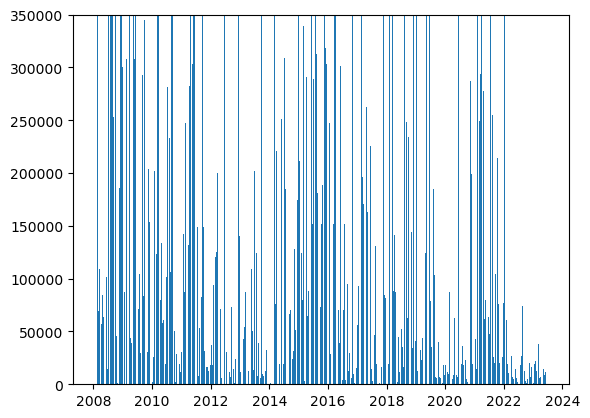

In [9]:
# Matplotlib had direct support for polars
import matplotlib.pyplot as plt
fix, ax = plt.subplots()
ax.bar(results['mydate'],results['totalvol'],width=1)
plt.ylim(0,350000)
plt.show()

In [10]:
# Showing a bar graph of total trades by date for AACG on the Nasdaq
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
plot = figure(width=1200, height=300, x_axis_type='datetime')
plot.line(x=results['mydate'],y=results['totalvol'])
plot.xaxis.axis_label = 'Date'
plot.yaxis.axis_label = 'Total Volume'
plot.title.text = 'AACG Total traded volume by date'
output_notebook()
show(plot)

Loading BokehJS ...

SerializationError: can't serialize <class 'polars.series.series.Series'>

In [13]:
# Showing a bar graph of total trades by date for AACG on the Nasdaq
from bokeh.io import output_notebook, show
from bokeh.models import Range1d
from bokeh.plotting import figure
plot = figure(width=1200, height=300, x_axis_type='datetime')
plot.line(x=results['mydate'].to_pandas(),y=results['totalvol'].to_list())
plot.xaxis.axis_label = 'Date'
plot.yaxis.axis_label = 'Total Volume'
plot.title.text = 'AACG Total traded volume by date'
plot.y_range = Range1d(0, 300000)
output_notebook()
show(plot)

Loading BokehJS ...

# Conclusions
- Matplotlib has native support for polars
- Bokeh does not support polars yet, workaround is extract vectors into a panda or list. (people are asking for it though https://github.com/bokeh/bokeh/issues/13210 )